In [1]:
import os
from PIL import Image
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.nn import functional as F

%matplotlib inline

In [2]:
CHAR_SET = list(string.ascii_lowercase) + [' ']
MAX_TURNS = 3
MAX_OUTPUT_LENGTH = 30
IMG_DIM = (3, 56, 56) # (3, 224, 224)

In [3]:
# Source: https://discuss.pytorch.org/t/list-of-nn-module-in-a-nn-module/219/2
# Use this over normal list or layers don't get registered
class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

In [4]:
# https://www.geeksforgeeks.org/python-program-to-find-whether-a-no-is-power-of-two/#:~:text=Given%20a%20positive%20integer%2C%20write,power%20of%20two%20or%20not.&text=1.,number%20is%20power%20of%202.
def is_power_of_two(n): 
    return (np.ceil(np.log2(n)) == np.floor(np.log2(n))); 

In [5]:
class Encoder(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.img_dim = img_dim
        
#         resnet = models.resnet34(pretrained=True)
#         resnet_modules = list(resnet.children())[1:-1]
        
        input_filter_count = 2 * img_dim[0]
#         self.conv_layer = nn.Conv2d(input_filter_count, 64, 7, stride=2, padding=3, bias=False)
#         self.resnet = nn.Sequential(*resnet_modules)
        
        
        
        self.downsampling_layer1 = nn.Sequential(
                nn.Conv2d(input_filter_count, 64, 4, stride=2, padding=1),
                nn.ReLU())
        self.downsampling_layer2 = nn.Sequential(
                nn.Conv2d(64, 128, 4, stride=2),
                nn.ReLU())
        self.downsampling_layer3 = nn.Sequential(
                nn.Conv2d(128, 256, 4, stride=2),
                nn.ReLU())
        self.downsampling_layer4 = nn.Sequential(
                nn.Conv2d(256, 512, 4, stride=2),
                nn.ReLU())
        self.lstm_prep_layer = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU())
        
#         self.resnet.required_grad = False
        self.lstm_layer = nn.LSTM(256, 256, batch_first=True)
        self.output_layer = nn.Linear(256, len(CHAR_SET))
        
    def forward(self, target_img, curr_img, lstm_state=None):
        full_input = torch.cat([target_img, curr_img], dim=1)
        
#         z = self.conv_layer(full_input)
        z = self.downsampling_layer1(full_input)
        z = self.downsampling_layer2(z)
        z = self.downsampling_layer3(z)
        z = self.downsampling_layer4(z)
        
#         z = self.resnet(z)
        # Only handling 1 sequence at a time, but multiple batches
        z = z.view(-1, 512) # batch, seq_len, hidden
        z = self.lstm_prep_layer(z)
        z = torch.unsqueeze(z, 1) # Add in sequence length
#         z = z.view(-1, 1, 256) # batch, seq_len, hidden
        z, new_lstm_state = self.lstm_layer(z, lstm_state)
        z = torch.squeeze(z, 1)
        logits = self.output_layer(z)
        
        one_hot = F.gumbel_softmax(logits, tau=1, dim=1, hard=True)
        char_idx = torch.argmax(logits, dim=1)
        
        return one_hot, char_idx, new_lstm_state

In [6]:
class Decoder(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.img_dim = img_dim
        assert img_dim[1] == img_dim[2], 'Only supports square imgs!'
        self.embeddings_dim = 14**2
        
        self.embeddings_layer = nn.Conv2d(1, self.embeddings_dim, (1, len(CHAR_SET)))
#         self.pooling_layer = nn.AdaptiveAvgPool2d((7, 7))
        
#         self.
    
        self.conv_layer1 = nn.Sequential(
                nn.Conv2d(30, 128, 3, padding=1),
                nn.ReLU())
        self.upsampling_layer1 = nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
                nn.ReLU())
#                 nn.BatchNorm2d(128))
        self.conv_layer2 = nn.Sequential(
                nn.Conv2d(64, 32, 3, padding=1),
                nn.ReLU())
#                 nn.BatchNorm2d(64))
        self.upsampling_layer2 = nn.Sequential(
                nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
                nn.ReLU())
                #nn.BatchNorm2d(3))
#         self.upsampling_layer4 = nn.Sequential(
#                 nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
#                 nn.ReLU(),
#                 nn.BatchNorm2d(16))
#         self.upsampling_layer5 = nn.Sequential(
#                 nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
#                 nn.ReLU())
        self.output_conv_layer = nn.Conv2d(3, 3, 1)
         
    def forward(self, descriptions): # Shape: (batch_size, seq_len, char_set_size)
        descriptions = torch.unsqueeze(descriptions, 1)
        
        z = self.embeddings_layer(descriptions)
        layer_size = int(np.sqrt(self.embeddings_dim))
        z = z.permute(0, 2, 1, 3)
        z = z.view(z.shape[0], z.shape[1], layer_size, layer_size)
        
        
#         z = self.pooling_layer(z)


        z = self.conv_layer1(z)
        z = self.upsampling_layer1(z)
        z = self.conv_layer2(z)
        z = self.upsampling_layer2(z)
        
        
#         z = self.upsampling_layer4(z)
#         z = self.upsampling_layer5(z)
        output = self.output_conv_layer(z)
        output = torch.clamp(output, 0, 1)
        
        return output

In [7]:
encoder = Encoder(IMG_DIM).to('cuda')
decoder = Decoder(IMG_DIM).to('cuda')

In [8]:
# Create input data
orig_imgs = torch.ones((2,) + IMG_DIM, device='cuda')
print(orig_imgs.shape)
curr_imgs = orig_imgs
lstm_state = None
outputs = []

# Generate encoder sequences
for seq_idx in range(MAX_OUTPUT_LENGTH):
    output, _, lstm_state = encoder(
        orig_imgs,
        curr_imgs,
        lstm_state)
    outputs.append(output.unsqueeze(1))

            
# String together output sequences
outputs = torch.cat(outputs, dim=1)
print(outputs.shape)

# Generate decoder output
gen_imgs = decoder(outputs)
print(gen_imgs.shape)

torch.Size([2, 3, 56, 56])
torch.Size([2, 30, 27])
torch.Size([2, 3, 56, 56])


In [12]:
# https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999
class ImgDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)
        self.img_cache = [None] * len(self.all_imgs)

    def shuffle(self):
        zipped_items = list(zip(self.all_imgs, self.img_cache))
        random.shuffle(zipped_items)
        self.all_imgs, self.img_cache = zip(*zipped_items)
        self.all_imgs = list(self.all_imgs)
        self.img_cache = list(self.img_cache)
        
    def get_batch_iter(self, batch_size):
        for i in range(0, len(self.all_imgs), batch_size):
            yield self[i:i+batch_size]
        
    def __len__(self):
        return len(self.all_imgs)

    def _load_img(self, idx):
        if self.img_cache[idx] is not None:
            return self.img_cache[idx]
        
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_img = self.transform(image).to('cuda')
        self.img_cache[idx] = tensor_img
        
        return tensor_img
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self._load_img(idx)
        elif isinstance(idx, slice):
            start = idx.start or 0
            end = idx.stop or len(self.all_imgs)
            step = idx.step or 1
            
            if start < 0:
                start = len(self.all_imgs) + start
            if end < 0:
                end = len(self.all_imgs) + end
            end = min(end, len(self.all_imgs))
            
            imgs = []
            for i in range(start, end, step):
                iter_img = self._load_img(i).unsqueeze(0)
                imgs.append(iter_img)
            imgs_tensor = torch.cat(imgs, dim=0)
            return imgs_tensor
    
def display_img(img):
    plt.imshow(img.permute(1, 2, 0))
    
def make_dataset(path):
    crop_size = IMG_DIM[1]
    transform = transforms.Compose([
       transforms.Resize(crop_size),
       transforms.CenterCrop(crop_size),
       transforms.ToTensor()
    ])

    return ImgDataSet(path, transform)

In [14]:
n_epochs = 5
batch_size = 16
log_freq = 20
lr = 0.001

In [15]:
dataset = make_dataset('data/')

In [16]:
loss_func = nn.MSELoss()
model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=lr)

In [17]:
loss_hist = []
for epoch in range(n_epochs):
    dataset.shuffle()
    data_iter = dataset.get_batch_iter(batch_size)
    for batch_idx, orig_img_batch in enumerate(data_iter):
        optimizer.zero_grad()
        
        # Prep data
        curr_img_batch = torch.zeros_like(orig_img_batch)
        curr_step_batch = torch.tensor([0] * curr_img_batch.shape[0]).to('cuda')
        lstm_state = None
        outputs = []
        
        # Generate encoder sequences
        for seq_idx in range(MAX_OUTPUT_LENGTH):
            output, _, lstm_state = encoder(
                orig_img_batch,
                curr_img_batch,
                lstm_state)
            outputs.append(output.unsqueeze(1))
            
        # String together output sequences
        outputs = torch.cat(outputs, dim=1)
        
        # Generate decoder output
        gen_img_batch = decoder(outputs)
        
        # Calculate loss and update weights
        loss = loss_func(gen_img_batch, orig_img_batch)
        loss_hist.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        
        # Ocasionally print losses
        if (batch_idx + 1) % log_freq == 0:
            avg_loss = np.mean(loss_hist[-batch_size:])
            print('Epoch #{} batch #{} | Avg loss: {:.4f}'.format(
                epoch+1, batch_idx+1, avg_loss))

Epoch #1 batch #20 | Avg loss: 0.2232
Epoch #1 batch #40 | Avg loss: 0.2354
Epoch #1 batch #60 | Avg loss: 0.2407
Epoch #1 batch #80 | Avg loss: 0.2356
Epoch #1 batch #100 | Avg loss: 0.2242
Epoch #1 batch #120 | Avg loss: 0.2243
Epoch #1 batch #140 | Avg loss: 0.2243
Epoch #1 batch #160 | Avg loss: 0.2420
Epoch #1 batch #180 | Avg loss: 0.2285
Epoch #1 batch #200 | Avg loss: 0.2306
Epoch #1 batch #220 | Avg loss: 0.2339
Epoch #1 batch #240 | Avg loss: 0.2226
Epoch #1 batch #260 | Avg loss: 0.2163
Epoch #1 batch #280 | Avg loss: 0.2291
Epoch #1 batch #300 | Avg loss: 0.2252
Epoch #1 batch #320 | Avg loss: 0.2287
Epoch #1 batch #340 | Avg loss: 0.2260
Epoch #1 batch #360 | Avg loss: 0.2270
Epoch #1 batch #380 | Avg loss: 0.2274
Epoch #1 batch #400 | Avg loss: 0.2219
Epoch #1 batch #420 | Avg loss: 0.2194
Epoch #1 batch #440 | Avg loss: 0.2266
Epoch #1 batch #460 | Avg loss: 0.2214
Epoch #1 batch #480 | Avg loss: 0.2305
Epoch #1 batch #500 | Avg loss: 0.2380
Epoch #2 batch #20 | Avg loss

In [18]:
test_batch_size = 1

dataset.shuffle()
data_iter = dataset.get_batch_iter(test_batch_size)
orig_img_batch = next(data_iter)

# Prep data
curr_img_batch = torch.zeros_like(orig_img_batch)
lstm_state = None
outputs = []
char_idxs = []

# Generate encoder sequences
for seq_idx in range(MAX_OUTPUT_LENGTH):
    output, char_idx, lstm_state = encoder(
        orig_img_batch,
        curr_img_batch,
        lstm_state)
    outputs.append(output.unsqueeze(1))
    char_idxs.append(char_idx)

# String together output sequences
# char_idxs = torch.cat(char_idxs, dim=1)
outputs = torch.cat(outputs, dim=1)

# Generate decoder output
gen_img_batch = decoder(outputs)

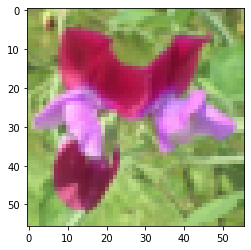

In [19]:
display_img(orig_img_batch[0].cpu())

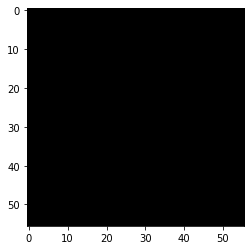

In [20]:
display_img(gen_img_batch[0].detach().cpu())